In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import re
import torch
import torchvision
import math

In [2]:
def lire_fichier(nom_fichier):
    data = []
    target = []
    
    with open(nom_fichier, 'r', encoding='utf-8') as fichier:
        for i, ligne in enumerate(fichier):
            ligne = re.sub('[\n\t]', '', ligne)
            if not ligne.strip():
                continue
            if ligne not in ["end", "<>", "<end>"]:
                elements = ligne.split(" ")
                if data:
                    data[-1].append(elements[0])
                else:
                    data.append([elements[0]])
                if target:
                    target[-1].append(elements[-1])
                else:
                    target.append([elements[-1]])
            elif ligne == "<>":
                data.append([])
                target.append([])
    
    return data, target

In [3]:
dataTrain, labelTrain =lire_fichier("protein-secondary-structure.train")
dataTest, labelTest  =lire_fichier("protein-secondary-structure.test")
print(dataTrain)
print('------------------------------------------------------')
print(dataTest)

[['G', 'V', 'G', 'T', 'V', 'P', 'M', 'T', 'D', 'Y', 'G', 'N', 'D', 'V', 'E', 'Y', 'Y', 'G', 'Q', 'V', 'T', 'I', 'G', 'T', 'P', 'G', 'K', 'S', 'F', 'N', 'L', 'N', 'F', 'D', 'T', 'G', 'S', 'S', 'N', 'L', 'W', 'V', 'G', 'S', 'V', 'Q', 'C', 'Q', 'A', 'S', 'G', 'C', 'K', 'G', 'G', 'R', 'D', 'K', 'F', 'N', 'P', 'S', 'D', 'G', 'S', 'T', 'F', 'K', 'A', 'T', 'G', 'Y', 'D', 'A', 'S', 'I', 'G', 'Y', 'G', 'D', 'G', 'S', 'A', 'S', 'G', 'V', 'L', 'G', 'Y', 'D', 'T', 'V', 'Q', 'V', 'G', 'G', 'I', 'D', 'V', 'T', 'G', 'G', 'P', 'Q', 'I', 'Q', 'L', 'A', 'Q', 'R', 'L', 'G', 'G', 'G', 'G', 'F', 'P', 'G', 'D', 'N', 'D', 'G', 'L', 'L', 'G', 'L', 'G', 'F', 'D', 'T', 'L', 'S', 'I', 'T', 'P', 'Q', 'S', 'S', 'T', 'N', 'A', 'F', 'D', 'Q', 'V', 'S', 'A', 'Q', 'G', 'K', 'V', 'I', 'Q', 'P', 'V', 'F', 'V', 'V', 'Y', 'L', 'A', 'A', 'S', 'N', 'I', 'S', 'D', 'G', 'D', 'F', 'T', 'M', 'P', 'G', 'W', 'I', 'D', 'N', 'K', 'Y', 'G', 'G', 'T', 'L', 'L', 'N', 'T', 'N', 'I', 'D', 'A', 'G', 'E', 'G', 'Y', 'W', 'A', 'L', 'N', 'V'

In [4]:
ac_am_dict = {
    "1" :[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "A": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "C": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "D": [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "E": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "F": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "G": [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "H": [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "I": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "K": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "L": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "M": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "N": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "P": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    "Q": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    "R": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    "S": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    "T": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "V": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    "W": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    "Y": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    
}

targ_dict = {
    
    "_": [1,0,0],
    "e": [0,1,0],
    "h": [0,0,1],
    
}

In [5]:
def transformAcideAminToSerieFive(data):   #La fonction transforme chaque séquence en une série de 5 acides aminés consécutifs,
                                           #en prenant en compte les acides aminés précédents et suivants
    compteur=0
    array=[]
    Finale = []
    for row in data:
        array=[]
        id=0
        compteur=compteur+(len(row))
        #pour chaque acide aminé la fonction vérifie si l'acide aminé est le premier ou le dernier de la séquence,
        #et ajoute l'acide aminé correspondant dans array
        for id, val in enumerate(row):
            if id==0   : 
                #verifier first acide
                array.append(ac_am_dict["1"])
                array.append(ac_am_dict["1"]) 
                array.append(ac_am_dict[val])
                    
            elif id==len(row)-1 :
                #vérifier last acide
                array.append(ac_am_dict[val])
                array.append(ac_am_dict["1"])
                array.append(ac_am_dict["1"])      
            else :  
                array.append(ac_am_dict[val])
        #parcourt chaque élément de array et construit une séquence de 5 acides aminés consécutifs
        
        for idx, val in enumerate(array):
            element=[]
            if (idx+1 < len(array) and idx - 1 >= 0 and idx+2 < len(array) and idx - 2 >= 0 ):
                #construction des séquence de 5 
                avant2=idx - 2
                avant1=idx - 1
                cur=idx
                apres1=idx+1
                apres2=idx+2   
                element = [*array[avant2],*array[avant1],*array[cur],*array[apres2],*array[apres1]]
                print(element)
                Finale.append(element)#et j'ajoute à la liste finale
        
    print('nombre d\'acide aminé',compteur)
    
    
    return Finale 

In [6]:
def TransformTarget(label):
    array2=[]
    FinaleTarget = []
    for row in label:
        array2=[]
        for va in row:
            FinaleTarget.append(targ_dict[va])
    return FinaleTarget

In [7]:
print(len(dataTrain),len(labelTrain))

111 111


In [8]:
TrainFinaleX=transformAcideAminToSerieFive(dataTrain)

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 

In [9]:
print(len(TrainFinaleX))
print(np.array(TrainFinaleX[0:10]))


18105
[[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]]


In [10]:
TrainFinaleY=TransformTarget(labelTrain)
#print    
print('nombre de labels',len(TrainFinaleY))
print(TrainFinaleY)

nombre de labels 18105
[[1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0

In [11]:
class Dataset(Dataset):

    def __init__(self,FinaleX,FinaleY):
        # Initialize data, download, etc.
        # read with numpy or pandas
        

        # here the first column is the class label, the rest are the features
        lst1 = [torch.from_numpy(np.array(item)).type(torch.float) for item in FinaleX]
        print(type(lst1))
        self.x_data = lst1
        lst2=[]
        for item in FinaleY :
            lst2.append(torch.from_numpy(np.array(item)).type(torch.float))
        
        self.y_data = lst2

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return len(self.y_data)


In [12]:
dataset = Dataset(TrainFinaleX,TrainFinaleY)
first_data = dataset[1]
features, labels = first_data
print(first_data)

<class 'list'>
(tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]), tensor([1., 0., 0.]))


In [13]:
print(len(dataset))

18105


In [14]:
train, valid = torch.utils.data.random_split(dataset,[14505,3600])#réduction de 20% les données d'entrainement
print(valid)

In [15]:
train_loader = DataLoader(dataset=train,batch_size=64, shuffle=True)
val_loader=DataLoader(dataset=valid,batch_size=64, shuffle=True)

In [16]:
TestFinaleX=transformAcideAminToSerieFive(dataTest)        
#print(len(TestFinaleX))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 

In [17]:
TestFinaleY=TransformTarget(labelTest)
#print    
print('nombre de labels',len(TestFinaleY))
print(len(TestFinaleY))

nombre de labels 3520
3520


In [18]:
dataset = Dataset(TestFinaleX,TestFinaleY)
test_loader = DataLoader(dataset=dataset,batch_size=64, shuffle=True)

<class 'list'>


In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NeuralNetwork(nn.Module):
    def __init__(self):

        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(22*5, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            
        )
        self.drops = nn.Dropout(0.0)
    def forward(self, x):
        x = self.flatten(x)
        x=self.drops(x)
        logits = self.linear_relu_stack(x)
        out = F.softmax(logits, dim=1)
        return out

model = NeuralNetwork()
criterion = torch.nn.MSELoss() # Meilleur avec Adam que SGD optimizer
#criterion = torch.nn.CrossEntropyLoss() # mons bonne with Adam optimizer
#optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)# moins bonne
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001) # Good Accuracy
#optimizer = optim.Adam(params=model.parameters(),lr=0.0001,eps=1e-8,weight_decay=0.01,amsgrad=True)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
  (drops): Dropout(p=0.0, inplace=False)
)


In [20]:
def saveModel(): 
    path = "./model.pth" 
    torch.save(model.state_dict(), path) 

In [21]:
import matplotlib.pyplot as plt

In [22]:
def train(num_epochs, early_stopping_patience=5):
    # Initialisation
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0.0
    epochs_without_improvement = 0

    # Boucle d'entraînement
    print("Début de l'entraînement...")
    for epoch in range(1, num_epochs + 1):
        running_train_loss = 0.0
        running_accuracy = 0.0
        running_val_loss = 0.0
        total = 0

        # Boucle d'entraînement
        model.train()
        for data in train_loader:
            inputs, outputs = data
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            train_loss = criterion(predicted_outputs, outputs)
            train_loss.backward()
            optimizer.step()
            running_train_loss += train_loss.item()

        # Calculer la perte d'entraînement
        train_loss_value = running_train_loss / len(train_loader)
        train_losses.append(train_loss_value)

        # Boucle de validation
        with torch.no_grad():
            model.eval()
            for data in val_loader:
                inputs, outputs = data
                predicted_outputs = model(inputs)
                val_loss = criterion(predicted_outputs, outputs)

                # La plus grande valeur sera notre prédiction
                predicted = torch.argmax(predicted_outputs, 1)
                outputs = torch.argmax(outputs, 1)
                running_val_loss += val_loss.item()
                total += outputs.size(0)
                running_accuracy += (predicted == outputs).sum().item()

        # Calculer la perte de validation
        val_loss_value = running_val_loss / len(val_loader)
        val_losses.append(val_loss_value)

        # Calculer la précision
        accuracy = (100 * running_accuracy / len(val_loader.dataset))
        train_accuracies.append(accuracy)

        # Sauvegarder notre modèle si c'est le meilleur jusqu'à présent
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement == early_stopping_patience:
                print("Early stopping après {} époques sans amélioration".format(early_stopping_patience))
                break

        val_accuracies.append(best_accuracy)

        # Afficher les statistiques de l'époque
        print('Epoch [{}/{}], Training Loss: {:.4f}, Validation Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch, num_epochs, train_loss_value, val_loss_value, accuracy))

    # Tracer les courbes si demandé
    #if plot_training:
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

        # Courbes de perte
    axs[0].plot(train_losses, label='Training loss')
    axs[0].plot(val_losses, label='Validation loss')
    axs[0].set_title("Courbes de perte")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Perte")
    axs[0].legend()

        # Courbes d'accuracy
    axs[1].plot(train_accuracies, label='Training accuracy')
    axs[1].plot(val_accuracies, label='Validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()


Début de l'entraînement...
Epoch [1/100], Training Loss: 0.2096, Validation Loss: 0.1962, Accuracy: 54.36%
Epoch [2/100], Training Loss: 0.1924, Validation Loss: 0.1888, Accuracy: 54.36%
Epoch [3/100], Training Loss: 0.1846, Validation Loss: 0.1811, Accuracy: 54.94%
Epoch [4/100], Training Loss: 0.1775, Validation Loss: 0.1765, Accuracy: 56.92%
Epoch [5/100], Training Loss: 0.1734, Validation Loss: 0.1737, Accuracy: 57.50%
Epoch [6/100], Training Loss: 0.1708, Validation Loss: 0.1721, Accuracy: 58.22%
Epoch [7/100], Training Loss: 0.1687, Validation Loss: 0.1700, Accuracy: 59.28%
Epoch [8/100], Training Loss: 0.1669, Validation Loss: 0.1695, Accuracy: 59.78%
Epoch [9/100], Training Loss: 0.1657, Validation Loss: 0.1687, Accuracy: 60.00%
Epoch [10/100], Training Loss: 0.1648, Validation Loss: 0.1681, Accuracy: 60.28%
Epoch [11/100], Training Loss: 0.1642, Validation Loss: 0.1680, Accuracy: 60.36%
Epoch [12/100], Training Loss: 0.1635, Validation Loss: 0.1677, Accuracy: 60.44%
Epoch [13/

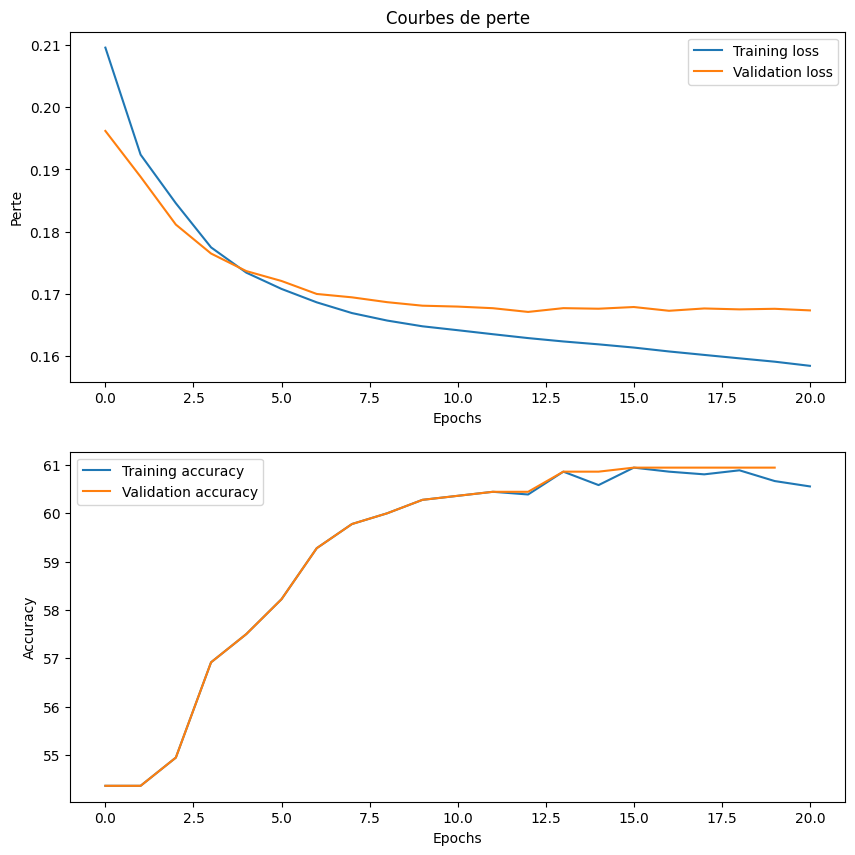

In [23]:
train(100, 5)

In [24]:
def test():
    model = NeuralNetwork()
    model.load_state_dict(torch.load('model.pth'))
    correct = 0
    total = 0
    accuracies = []

    with torch.no_grad():
        model.eval()
        for inputs, targets in test_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            predited_labels = torch.argmax(outputs, 1)
            correct_labels = torch.argmax(targets, 1)
            correct += (predited_labels == correct_labels).sum().item()
            total += targets.size(0)
            accuracy = 100 * correct / total
            accuracies.append(accuracy)

    plt.plot(accuracies, label='Test accuracy')
    plt.title('Test accuracy over time')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

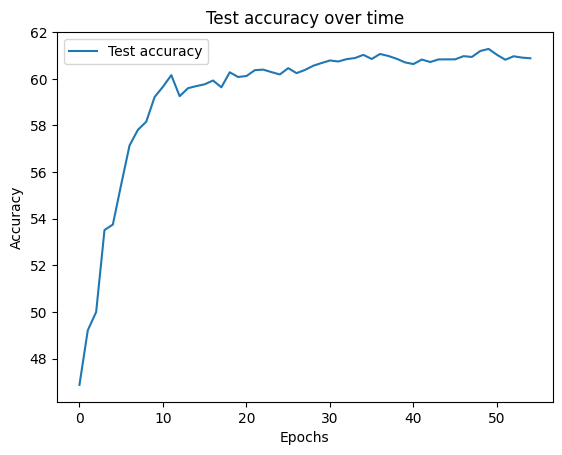

In [25]:
test()